In [1]:
#import src.functions as func
from src.functions import load_data, scale, baseline_model_fit_save, bootstrap_evaluate, compute_confidence_interval, plot_metrics_boxplot, elasticnet_feature_selection, hyperparameter_tuning_save
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet, BayesianRidge
from sklearn.svm import SVR

In [2]:
dev_data_path = "data/assignment1_dev_set.csv"
val_data_path = "data/assignment1_val_set.csv"
# Load and split data
X_train, y_train = load_data(dev_data_path)
X_test, y_test = load_data(val_data_path)

#X_train, X_test = scale(X_train, X_test)

In [3]:
X_train

,Acholeplasma axanthum,Acidaminococcus fermentans,Acidaminococcus intestini,Actinomyces lingnae,Akkermansia muciniphila,Alistipes finegoldii,Alistipes indistinctus,Alistipes obesi,Alistipes onderdonkii,Alistipes putredinis,...,Clostridium sphenoides,Clostridium spiroforme,Clostridium stercorarium,Clostridium symbiosum,Clostridium thermosuccinogenes,Clostridium xylanolyticum,Eubacterium brachy,Eubacterium dolichum,Eubacterium sulci,Ruminococcus gnavus
0,0.000000,0.000000,0.000000,0.000000,0.017674,0.000000,0.000000,0.00000,0.117827,0.005891,...,0.005891,0.029457,0.000000,0.000000,0.002946,0.000000,0.000000,0.000000,0.002946,0.100153
1,0.001028,0.000000,0.000000,0.000000,13.015800,0.001542,0.000000,0.00000,0.073486,0.403916,...,0.000000,0.002569,0.412652,0.003083,0.000000,0.000000,0.008736,0.014903,0.077597,0.004625
2,0.001406,0.000000,0.000000,0.001406,0.002812,0.201074,0.000000,0.00000,0.043590,0.105459,...,0.000000,0.005624,0.002812,0.007031,0.000000,0.000000,0.000000,0.000000,0.005624,0.016873
3,0.000000,0.008825,0.273562,0.000000,0.044123,0.004412,0.348570,0.00000,0.026474,0.586834,...,0.017649,0.198553,0.000000,0.158842,0.030886,0.101483,0.000000,0.000000,0.000000,0.000000
4,0.002878,0.037419,7.359970,0.000000,0.872143,0.000000,0.000000,0.00000,1.732770,1.004550,...,0.305106,0.135283,0.000000,0.051811,0.054689,0.083473,0.020148,0.000000,0.054689,0.011513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,0.000000,0.000000,0.000000,0.000000,0.509040,0.015800,0.018390,0.06278,0.059660,2.620060,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002160,0.000000,0.000000
485,0.000000,0.000000,0.000000,0.000000,0.005112,0.015139,0.000000,0.00000,0.020054,0.226497,...,0.000000,0.017105,0.001770,0.032834,0.000000,0.000590,0.000393,0.000000,0.000197,0.004522
486,0.000000,0.000000,0.000000,0.000000,0.052094,0.093770,0.000000,0.00000,0.211850,1.722580,...,0.000000,0.309092,0.052094,0.197958,0.000000,0.006946,0.000000,0.017365,0.065986,0.000000
487,0.001556,0.001556,0.122888,0.000000,0.000000,0.001556,0.045111,0.00000,0.090222,0.455776,...,0.017111,0.057555,0.000000,0.054444,0.000000,0.045111,0.010889,0.000000,0.009333,0.018667


Bootstrapping evaluation for ElasticNet on evaluation data...
95% CI for RMSE: (np.float64(3.565593296970234), np.float64(5.954774607979159))
95% CI for MAE: (np.float64(2.4554960709131124), np.float64(3.4402142839248118))
95% CI for R2: (np.float64(-1.3328014073565373), np.float64(0.14280964377348024))
Bootstrapping evaluation for SVR on evaluation data...
95% CI for RMSE: (np.float64(3.195909922664964), np.float64(4.347558991282406))
95% CI for MAE: (np.float64(2.133509943299336), np.float64(2.7800887011287734))
95% CI for R2: (np.float64(0.029943540942207535), np.float64(0.1487314790671319))
Bootstrapping evaluation for BayesianRidge on evaluation data...
95% CI for RMSE: (np.float64(3.2145394419692517), np.float64(4.364680443915949))
95% CI for MAE: (np.float64(2.269495735132842), np.float64(2.9538476750914615))
95% CI for R2: (np.float64(-0.04518816942351646), np.float64(0.23936286479267055))


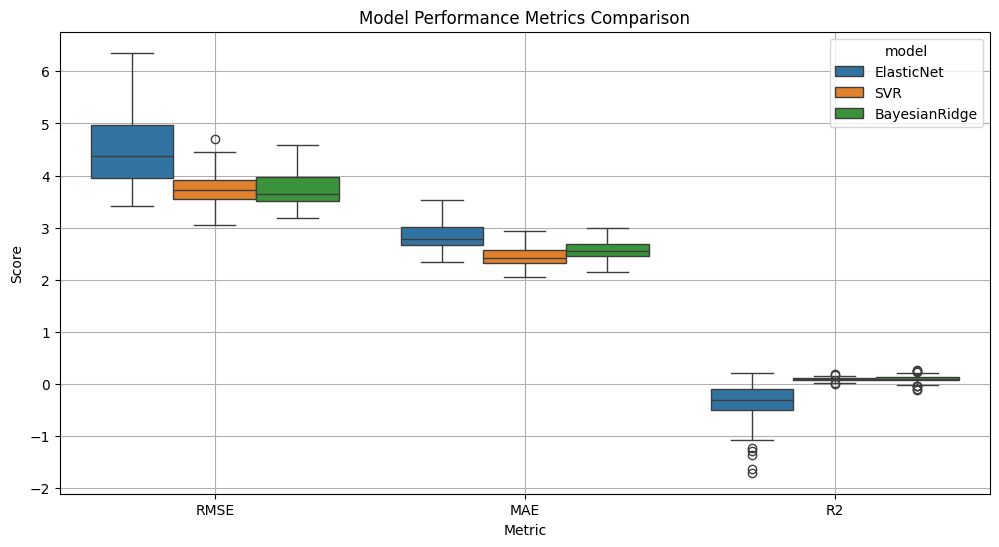

In [4]:
# Define models
models = {
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "SVR": SVR(C=1.0, epsilon=0.2),
    "BayesianRidge": BayesianRidge()
}

evaluation_results = []

# Evaluate each model on the development dataset and then on the evaluation dataset
for name, model in models.items():
    
    baseline = baseline_model_fit_save(model, name, X_train=X_train, y_train=y_train)
    
    print(f"Bootstrapping evaluation for {name} on evaluation data...")
    eval_metrics = bootstrap_evaluate(model, X_test, y_test, n_bootstraps=100)
    rmse_ci = compute_confidence_interval(eval_metrics['RMSE'])
    mae_ci = compute_confidence_interval(eval_metrics['MAE'])
    r2_ci = compute_confidence_interval(eval_metrics['R2'])

    print("95% CI for RMSE:", rmse_ci)
    print("95% CI for MAE:", mae_ci)
    print("95% CI for R2:", r2_ci)
    eval_metrics['model'] = name
    evaluation_results.append(eval_metrics)

# Combine evaluation results for boxplot comparison
combined_eval_df = pd.concat(evaluation_results, ignore_index=True)


# Plot the evaluation metrics for all models
plot_metrics_boxplot(combined_eval_df, save_path="plots/baseline_evaluation_metrics_boxplot.png")

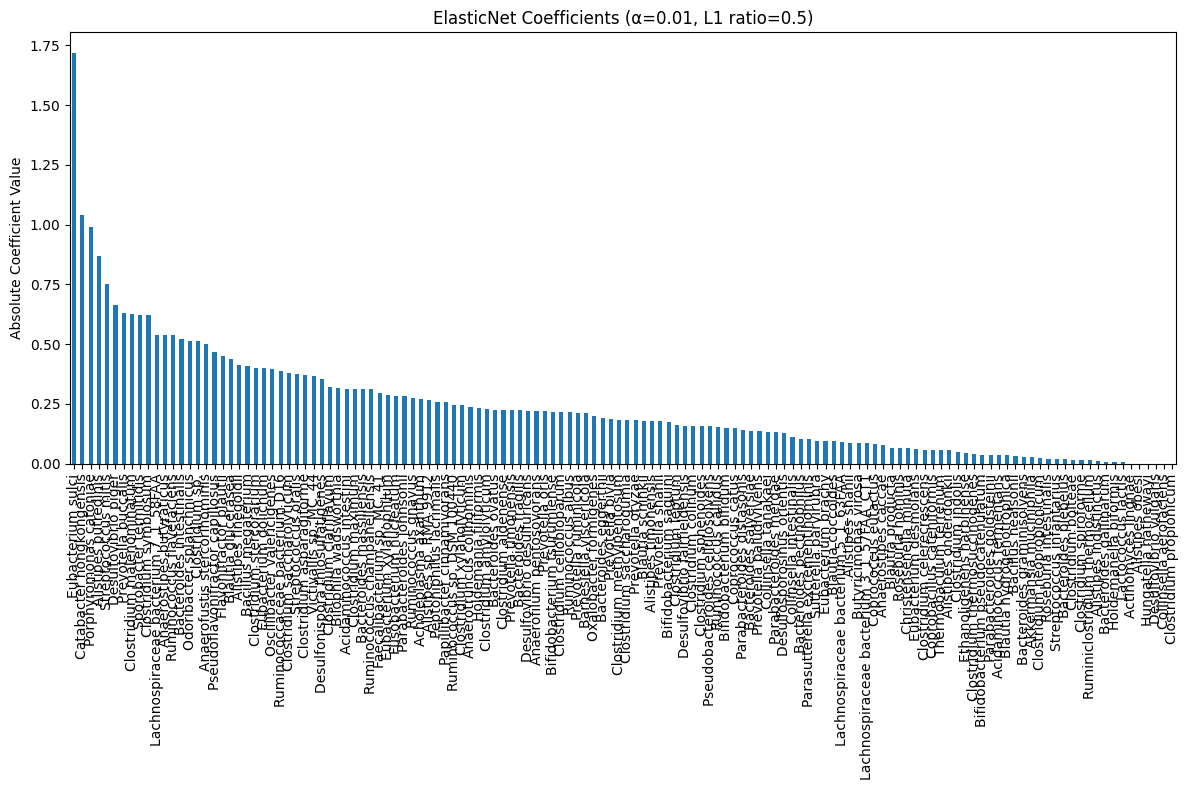

In [3]:
selected_features, coefs = elasticnet_feature_selection(X_train, y_train, 
                       alpha=0.01, l1_ratio=0.5)


Bootstrapping evaluation for ElasticNet on evaluation data after feature selection...
95% CI for RMSE: (np.float64(3.3384996726470657), np.float64(4.324980489380795))
95% CI for MAE: (np.float64(2.366640091977826), np.float64(2.9308569830579136))
95% CI for R2: (np.float64(-0.0006003414605977911), np.float64(0.1140801700641659))
Bootstrapping evaluation for SVR on evaluation data after feature selection...
95% CI for RMSE: (np.float64(3.2337340077632803), np.float64(4.466003082055641))
95% CI for MAE: (np.float64(2.283594759539905), np.float64(2.8681469684747576))
95% CI for R2: (np.float64(-0.0034426998108105455), np.float64(0.11389204747054033))
Bootstrapping evaluation for BayesianRidge on evaluation data after feature selection...
95% CI for RMSE: (np.float64(3.3955033214727384), np.float64(4.4252318629152025))
95% CI for MAE: (np.float64(2.357409282545377), np.float64(3.0491077505428548))
95% CI for R2: (np.float64(-0.07034008621827548), np.float64(0.16814970832101528))


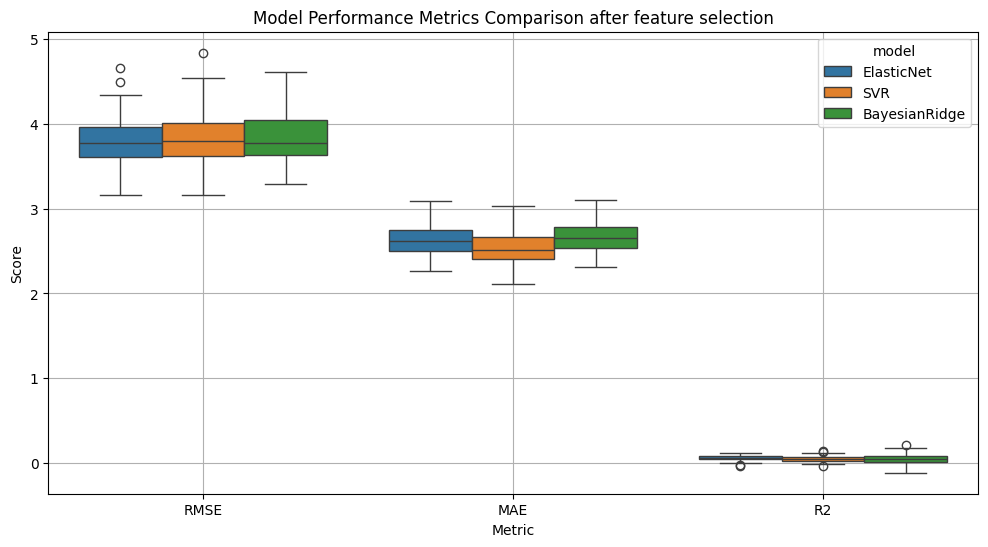

In [4]:
# Define models
models = {
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "SVR": SVR(C=1.0, epsilon=0.2),
    "BayesianRidge": BayesianRidge()
}

    
# Create DataFrame with selected features
X_train_selected = pd.DataFrame(X_train, columns=selected_features)
X_test_selected = pd.DataFrame(X_test, columns=selected_features)

evaluation_results = []

# Evaluate each model on the development dataset and then on the evaluation dataset
for name, model in models.items():
    
    baseline = baseline_model_fit_save(model, name, X_train=X_train_selected, y_train=y_train)
    
    print(f"Bootstrapping evaluation for {name} on evaluation data after feature selection...")
    eval_metrics = bootstrap_evaluate(model, X_test_selected, y_test, n_bootstraps=100)
    rmse_ci = compute_confidence_interval(eval_metrics['RMSE'])
    mae_ci = compute_confidence_interval(eval_metrics['MAE'])
    r2_ci = compute_confidence_interval(eval_metrics['R2'])

    print("95% CI for RMSE:", rmse_ci)
    print("95% CI for MAE:", mae_ci)
    print("95% CI for R2:", r2_ci)
    eval_metrics['model'] = name
    evaluation_results.append(eval_metrics)

# Combine evaluation results for boxplot comparison
combined_eval_df = pd.concat(evaluation_results, ignore_index=True)


# Plot the evaluation metrics for all models
plot_metrics_boxplot(combined_eval_df, name = "Model Performance Metrics Comparison after feature selection", save_path="plots/FS_evaluation_metrics_boxplot.png")


=== Tuning ElasticNet ===
Best parameters: {'alpha': 1, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': np.float64(0.1), 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}

=== Tuning SVR ===
Best parameters: {'C': 1, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}

=== Tuning BayesianRidge ===
Best parameters: {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'alpha_init': None, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 0.0001, 'lambda_2': 1e-06, 'lambda_init': None, 'max_iter': 300, 'tol': 0.001, 'verbose': False}

=== Evaluating tuned ElasticNet ===
95% CI for RMSE: (np.float64(3.366273016077079), np.float64(4.412758256591467))
95% CI for MAE: (np.float64(2.46490050219867), np.float64(3.054343026847732))
95% CI for R2: (np.float64(-0.018406264840348033), n

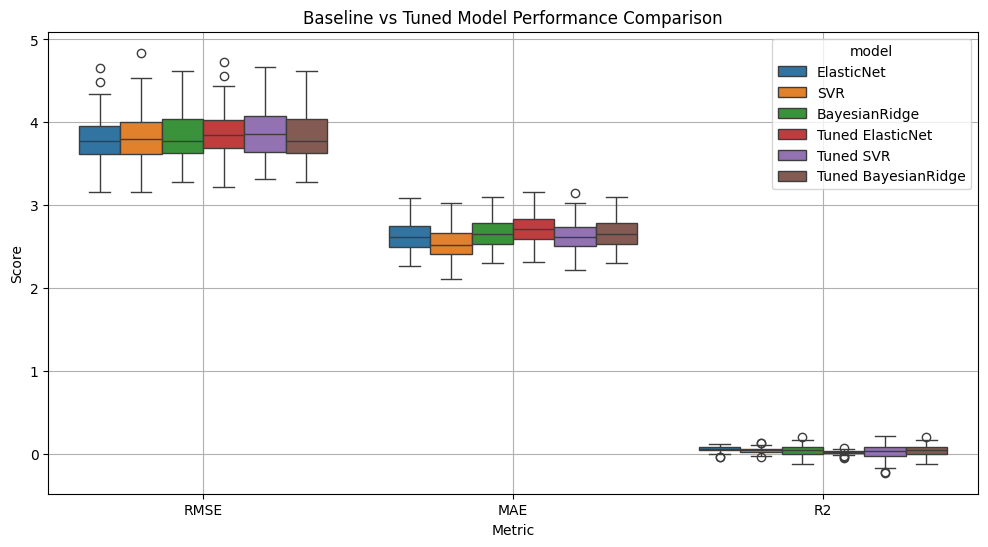

In [5]:
# Define models with their parameter grids
tuning_config = {
    "ElasticNet": {
        "model": ElasticNet(),
        "params": {
            "alpha": [0.001, 0.01, 0.1, 1, 10],
            "l1_ratio": np.arange(0.1, 1.0, 0.1)
        }
    },
    "SVR": {
        "model": SVR(),
        "params": {
            "C": [0.1, 1, 10],
            "epsilon": [0.01, 0.1, 0.5],
            "kernel": ["linear", "rbf"]
        }
    },
    "BayesianRidge": {
        "model": BayesianRidge(),
        "params": {
            "alpha_1": [1e-6, 1e-5, 1e-4],
            "lambda_1": [1e-6, 1e-5, 1e-4]
        }
    }
}

# Perform hyperparameter tuning
tuned_models = {}
for name, config in tuning_config.items():
    print(f"\n=== Tuning {name} ===")
    best_model, cv_results = hyperparameter_tuning_save(
        config["model"], 
        name,
        config["params"],
        X_train_selected,
        y_train,
        cv=5
    )
    tuned_models[name] = best_model
    print(f"Best parameters: {best_model.get_params()}")

# Evaluate tuned models
tuned_evaluation_results = []
for name, model in tuned_models.items():
    print(f"\n=== Evaluating tuned {name} ===")
    eval_metrics = bootstrap_evaluate(model, X_test_selected, y_test)
    
    # Calculate confidence intervals
    rmse_ci = compute_confidence_interval(eval_metrics['RMSE'])
    mae_ci = compute_confidence_interval(eval_metrics['MAE'])
    r2_ci = compute_confidence_interval(eval_metrics['R2'])

    print(f"95% CI for RMSE: {rmse_ci}")
    print(f"95% CI for MAE: {mae_ci}")
    print(f"95% CI for R2: {r2_ci}")
    
    eval_metrics['model'] = f"Tuned {name}"
    tuned_evaluation_results.append(eval_metrics)

# Combine baseline and tuned results
full_results = pd.concat(
    [combined_eval_df, pd.concat(tuned_evaluation_results)], 
    ignore_index=True
)

# Plot comparison
plot_metrics_boxplot(
    full_results,
    name="Baseline vs Tuned Model Performance Comparison",
    save_path="plots/tuned_comparison_boxplot.png"
)